In [1]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!python -m spacy download en_core_web_md

import pandas as pd
from datetime import datetime
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to the CSV file in Google Drive
file_path =("/content/drive/MyDrive/Colab Notebooks/Matt/result (1).csv")

# Load the LI scrapper CSV file
df = pd.read_csv(file_path)
df = df[df['company'].str.contains(r'\bkpmg\b', case=False, na=False)]


# Path to the CSV file in Google Drive
file_path2 =("/content/drive/MyDrive/Colab Notebooks/Matt/Tech Group.csv")

# Load the Tech Group CSV file
new_titles_df = pd.read_csv(file_path2)

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
len(df)

602

In [5]:
new_titles_df

,Full Name,First Name,Last Name,Year Started,Title,Team
0,Mahendra Aavula,Mahendra,Aavula,2021.0,Manager,Tech Implementation
1,Penny Abbott,Penny,Abbott,2017.0,Manager,Tech Advisory
2,Hameed Shoaib Abdul,Hameed,Shoaib Abdul,2020.0,Manager,Tech Implementation
3,Aniruddha Abhyankar,Aniruddha,Abhyankar,2020.0,Manager,Data Analytics & AI
4,Temitayo Abiodun,Temitayo,Abiodun,2019.0,Manager,Tech Advisory
...,...,...,...,...,...,...
1457,Haijin Zhu,Haijin,Zhu,2017.0,Manager,Tech Enablement
1458,Ryan Zhu,Ryan,Zhu,2021.0,Manager,Data Analytics & AI
1459,Minian Zou,Minian,Zou,2019.0,Senior Consultant,Tech Advisory
1460,Darin Zukerman,Darin,Zukerman,2020.0,Senior Consultant,Data Analytics & AI


In [6]:
# Function to match and update job titles using fuzzy matching
def update_job_titles(df, new_titles_df):
    for i, row in df.iterrows():
        # Find the best match for each fullName in the new_titles_df
        best_match = process.extractOne(row['fullName'], new_titles_df['Full Name'])
        matched_name, score, match_index = best_match

        if score >= 80:  # You can adjust the threshold as needed
            new_title = new_titles_df.at[match_index, 'Title']
            df.at[i, 'jobTitle'] = new_title
        else:
            print(f"No suitable match found for {row['fullName']} with score {score}")

# Update the job titles in the main DataFrame
update_job_titles(df, new_titles_df)

print("\nMain DataFrame after update:")
print(df.head(10))



Main DataFrame after update:
                                   linkedinProfileUrl email  \
2   https://www.linkedin.com/in/will-adams-994934174/   NaN   
4   https://www.linkedin.com/in/ammrith-adithya-43...   NaN   
6   https://www.linkedin.com/in/prabin-agarwal-520...   NaN   
7    https://www.linkedin.com/in/priyankaagarwal2000/   NaN   
8   https://www.linkedin.com/in/akansha-aggarwal-2...   NaN   
9   https://www.linkedin.com/in/pallavi-aggarwal-7...   NaN   
10       https://www.linkedin.com/in/saurabhagrahari/   NaN   
14  https://www.linkedin.com/in/tyler-aitken-1176a...   NaN   
15            https://www.linkedin.com/in/luis-ajero/   NaN   
16          https://www.linkedin.com/in/philip-alava/   NaN   

                                      linkedinProfile  \
2   https://www.linkedin.com/in/will-adams-994934174/   
4   https://www.linkedin.com/in/ammrith-adithya-43...   
6   https://www.linkedin.com/in/prabin-agarwal-520...   
7    https://www.linkedin.com/in/priyankaagarwal

In [7]:
unique_job_titles = df['jobTitle'].unique()
print(unique_job_titles, len(df))

['Senior Consultant' 'Consultant' 'Associate Director' 'Manager'
 'Director' 'Partner'] 602


## Assumptions and Definitions:
- Job Date Range Format: The job date range is provided in the format "MMM YYYY - MMM YYYY" or "YYYY - YYYY". This can include an additional description of the duration in the format "· X mos".
- "Present" Keyword: The end date can be "Present", which is interpreted as the current date.
- Skills and Endorsements: Six skill and endorsement columns are considered (skill1 to skill6, endorsement1 to endorsement6).
- Education: Two education columns are considered (school and school2).
- Dynamic Tenure Categories:
-- Junior: Less than the 33rd percentile of tenure years.
-- Mid-level: Between the 33rd and 66th percentiles of tenure years.
-- Senior: More than the 66th percentile of tenure years.

# Code Functions:
- extract_job_dates: Extracts the start and end dates from the job date range, handling formats "MMM YYYY" and "YYYY", and interprets "Present" as the current date.
- calculate_tenure: Calculates the tenure in years as a floating-point number, converting the duration from days to months and then to years.
- categorize_tenure: Dynamically categorizes the tenure into Junior, Mid-level, and Senior based on the 33rd and 66th percentiles of the tenure years.
- summarize_group: Summarizes key details for each group, including average, minimum, and maximum tenure, skills, endorsements, education, job locations, and companies.

# Output:
The profiles DataFrame contains aggregated data for each job title and tenure category, including summarized details of tenure, skills, endorsements, education, locations, and companies. The tenure categories are dynamically assigned based on the data distribution.


# Created the Profiles for each seniority and role



In [12]:
# Experimental code
# Now uses AI and went from instant to taking 23 mins to run lol

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Expanded mapping of common degree names to categories
degree_mapping = {
    'Bachelor': ['BSc', 'BA', 'BE', 'BEng', 'BS', 'BBA', 'BCom', 'BArch', 'BTech', 'Bachelor'],
    'Master': ['MSc', 'MA', 'MBA', 'MEng', 'MS', 'MPhil', 'MRes', 'MFA', 'MPA', 'MHA', 'MPH', 'LLM', 'Master'],
    'PhD': ['PhD', 'Doctorate', 'DPhil', 'EdD', 'DBA', 'DSc', 'JD', 'MD', 'DO'],
    'Associate': ['Associate', 'AS', 'AA', 'AAS'],
    'Diploma': ['Diploma', 'Certificate', 'Cert'],
    'High School': ['High School', 'Secondary', 'HSC', 'GCE', 'GED', 'A-Level', 'O-Level', 'SSC']
}

# Expanded mapping of degree fields to categories
field_mapping = {
    'Business': ['Business', 'Commerce', 'MBA', 'Management', 'Finance', 'Accounting', 'Marketing', 'Economics', 'HR', 'Human Resources'],
    'Data': ['Data', 'Analytics', 'Statistics', 'Big Data', 'Data Science', 'Data Analysis'],
    'IT': ['IT', 'Information Technology', 'Computer Science', 'CS', 'Software Engineering', 'Information Systems', 'Cybersecurity'],
    'Engineering': ['Engineering', 'Mechanical', 'Electrical', 'Civil', 'Chemical', 'Aerospace', 'Biomedical', 'Industrial', 'Environmental'],
    'Science': ['Biology', 'Physics', 'Chemistry', 'Science', 'Biochemistry', 'Environmental Science', 'Earth Science', 'Mathematics', 'Geology', 'Astronomy'],
    'Arts': ['Arts', 'Humanities', 'History', 'Philosophy', 'Literature', 'Linguistics', 'Fine Arts', 'Performing Arts'],
    'Health': ['Health', 'Medicine', 'Nursing', 'Pharmacy', 'Public Health', 'Dentistry', 'Veterinary', 'Physical Therapy', 'Occupational Therapy', 'Healthcare Administration'],
    'Law': ['Law', 'Legal', 'Jurisprudence', 'LLB', 'LLM']
}

# Skill categories for technology consultants
skill_categories = {
    'Data & Analytics': [
        'Data Analysis', 'Data Architecture', 'Data Governance', 'Data Modeling', 'Data Visualization',
        'Analytics', 'Reporting & Analysis', 'Data Engineering', 'Business Intelligence', 'Advanced Analytics',
        'Big Data', 'Data Warehousing', 'Data Strategies', 'Data Management', 'Data Science',
        'Statistical Analysis', 'Machine Learning', 'Predictive Modeling', 'Data Migration',
        'Data Integration', 'Data Quality', 'Data Strategy', 'Data Governance'
    ],
    'Software Development & Programming': [
        'Python', 'Java', 'JavaScript', 'C++', 'SQL', '.NET', 'C#', 'HTML', 'CSS', 'JavaSE', 'Node.js',
        'R', 'PHP', 'Ruby', 'Scala', 'Objective-C', 'Swift'
    ],
    'Business & Management': [
        'Business Process Improvement', 'Business Transformation', 'Operational Planning', 'Management Consulting',
        'Strategy Consulting', 'Project Management', 'Program Management', 'Business Analysis',
        'Business Strategy', 'Change Management', 'Governance', 'Stakeholder Management',
        'Strategic Planning', 'Risk Management', 'Business Development', 'IT Strategy', 'IT Audit',
        'Business Case Development', 'Financial Analysis', 'Financial Modeling'
    ],
    'Cloud & Infrastructure': [
        'Cloud Computing', 'Cloud Architecture', 'Cloud Technology', 'Azure', 'AWS', 'Google Cloud Platform',
        'Infrastructure as Code (IaC)', 'Virtualization', 'Network Design', 'VMware', 'DevOps',
        'Azure DevOps', 'Infrastructure Management', 'IT Operations'
    ],
    'Customer & Client Engagement': [
        'Customer Service', 'CRM', 'Salesforce', 'Engagement Management', 'Client Relations',
        'Customer Experience', 'Customer Insight', 'Customer Satisfaction'
    ],
    'Leadership & Team Management': [
        'Team Leadership', 'Cross-functional Team Leadership', 'Team Management', 'Employee Engagement',
        'Coaching & Mentoring', 'Training and Development (HR)', 'Leading People'
    ],
    'Technology & Tools': [
        'Microsoft Office', 'Microsoft Excel', 'Microsoft PowerPoint', 'Microsoft Dynamics', 'SAP', 'Oracle',
        'Salesforce.com', 'ServiceNow', 'Workday', 'Tableau', 'Power BI', 'Jira', 'Confluence', 'SharePoint'
    ],
    'Compliance & Auditing': [
        'Auditing', 'IT Audit', 'Compliance', 'SOX', 'Internal Audits', 'External Audits', 'Governance',
        'Risk & Compliance (GRC)'
    ],
    'Methodologies & Frameworks': [
        'Agile Methodologies', 'Scrum', 'Waterfall Methodologies', 'ITIL', 'PRINCE2', 'Lean', 'Six Sigma',
        'Design Thinking'
    ],
    'Emerging Technologies': [
        'Artificial Intelligence (AI)', 'Machine Learning', 'Robotics', 'IoT', 'Blockchain', 'AR', 'VR'
    ]
}

# Function to preprocess and vectorize text
def preprocess_and_vectorize(text):
    doc = nlp(text.lower())
    return doc.vector

# Function to categorize skill dynamically
def categorize_skill(skill):
    skill_vector = preprocess_and_vectorize(skill)
    max_similarity = -1
    best_category = 'Other'
    for category, keywords in skill_categories.items():
        category_vector = np.mean([preprocess_and_vectorize(keyword) for keyword in keywords], axis=0)
        similarity = cosine_similarity([skill_vector], [category_vector])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            best_category = category
    return best_category
############################################################################
# Function to categorize degree types dynamically
def categorize_degree(degree):
    if pd.isna(degree):
        return 'Unknown'
    degree_vector = preprocess_and_vectorize(degree)
    max_similarity = -1
    best_category = 'Other'
    for category, keywords in degree_mapping.items():
        category_vector = np.mean([preprocess_and_vectorize(keyword) for keyword in keywords], axis=0)
        similarity = cosine_similarity([degree_vector], [category_vector])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            best_category = category
    return best_category

# Function to categorize degree fields dynamically
def categorize_field(degree):
    if pd.isna(degree):
        return 'Unknown'
    degree_vector = preprocess_and_vectorize(degree)
    max_similarity = -1
    best_category = 'Other'
    for category, keywords in field_mapping.items():
        category_vector = np.mean([preprocess_and_vectorize(keyword) for keyword in keywords], axis=0)
        similarity = cosine_similarity([degree_vector], [category_vector])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            best_category = category
    return best_category

# Function to calculate weighted skill scores
def calculate_weighted_skills(df):
    skill_cols = ['skill1', 'skill2', 'skill3', 'skill4', 'skill5', 'skill6']
    endorsement_cols = ['endorsement1', 'endorsement2', 'endorsement3', 'endorsement4', 'endorsement5', 'endorsement6']

    df['weighted_skills'] = df.apply(lambda row: {
        row[skill]: row[endorsement]
        for skill, endorsement in zip(skill_cols, endorsement_cols)
        if pd.notna(row[skill]) and pd.notna(row[endorsement])
    }, axis=1)
    return df

# Function to extract dates from the job date range
def extract_job_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].split('·')[0].strip() if len(dates) > 1 else 'Present'
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    if end_date_str == 'Present':
        end_date = datetime.now()
    else:
        try:
            end_date = datetime.strptime(end_date_str, '%b %Y')
        except ValueError:
            end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Function to calculate the tenure in years as a floating-point number
def calculate_tenure(start_date, end_date):
    if pd.isna(start_date):
        return None
    if pd.isna(end_date):
        end_date = datetime.now()
    duration_in_days = (end_date - start_date).days
    duration_in_months = duration_in_days / 30.44  # Average days per month
    duration_in_years = duration_in_months / 12
    return round(duration_in_years, 2)

# Function to extract graduation dates
def extract_education_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].split('·')[0].strip() if len(dates) > 1 else 'Present'
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    if end_date_str == 'Present':
        end_date = datetime.now()
    else:
        try:
            end_date = datetime.strptime(end_date_str, '%b %Y')
        except ValueError:
            end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Apply the functions to the DataFrame
df['jobStartDate'], df['jobEndDate'] = zip(*df['jobDateRange'].apply(extract_job_dates))
df['jobTenureYears'] = df.apply(lambda row: calculate_tenure(row['jobStartDate'], row['jobEndDate']), axis=1)

# Extract education dates
df['schoolStartDate'], df['schoolEndDate'] = zip(*df['schoolDateRange'].apply(extract_education_dates))
df['schoolStartDate2'], df['schoolEndDate2'] = zip(*df['schoolDateRange2'].apply(extract_education_dates))

# Apply the degree categorization functions
df['degreeCategory'] = df['schoolDegree'].apply(categorize_degree)
df['degreeCategory2'] = df['schoolDegree2'].apply(categorize_degree)
df['fieldCategory'] = df['schoolDegree'].apply(categorize_field)
df['fieldCategory2'] = df['schoolDegree2'].apply(categorize_field)

# Apply the weighted skills calculation
df = calculate_weighted_skills(df)

# Function to calculate total working experience since the lowest degree
def calculate_total_experience(row):
    if pd.notna(row['schoolEndDate']):
        lowest_degree_end_date = row['schoolEndDate']
    elif pd.notna(row['schoolEndDate2']):
        lowest_degree_end_date = row['schoolEndDate2']
    else:
        return None
    total_experience_years = (datetime.now() - lowest_degree_end_date).days / 365.25
    return round(total_experience_years, 2)

df['totalExperienceYears'] = df.apply(calculate_total_experience, axis=1)

# Calculate dynamic thresholds based on percentiles
percentiles = df['jobTenureYears'].quantile([0.33, 0.66]).values
junior_threshold = percentiles[0]
mid_level_threshold = percentiles[1]

# Function to categorize the tenure dynamically
def categorize_tenure(tenure_years):
    if pd.isna(tenure_years):
        return None
    if tenure_years < junior_threshold:
        return 'Junior'
    elif junior_threshold <= tenure_years < mid_level_threshold:
        return 'Mid-level'
    else:
        return 'Senior'

# Apply the dynamic categorization
df['jobTenureCategory'] = df['jobTenureYears'].apply(categorize_tenure)

# Function to summarize the groups
def summarize_group(group):
    # Extract unique skills
    skills = list(set(group[['skill1', 'skill2', 'skill3', 'skill4', 'skill5', 'skill6']].values.ravel()))
    skills = [skill for skill in skills if pd.notna(skill)]

    # Sum endorsements for each skill
    endorsements = {
        skill: group[endorsement_col].sum()
        for skill, endorsement_col in zip(skills, ['endorsement1', 'endorsement2', 'endorsement3', 'endorsement4', 'endorsement5', 'endorsement6'])
        if skill in skills
    }

    # Calculate weighted skills
    weighted_skills = {}
    for skill, endorsement in endorsements.items():
        category = categorize_skill(skill)
        if category in weighted_skills:
            weighted_skills[category] += endorsement
        else:
            weighted_skills[category] = endorsement

    # Get the top weighted skills
    top_skills = sorted(weighted_skills.items(), key=lambda x: x[1], reverse=True)

    # Extract unique degree types and fields
    degrees = list(set(group[['degreeCategory', 'degreeCategory2']].values.ravel()))
    degrees = [degree for degree in degrees if pd.notna(degree)]
    fields = list(set(group[['fieldCategory', 'fieldCategory2']].values.ravel()))
    fields = [field for field in fields if pd.notna(field)]

    summary = {
        'average_tenure_years': group['jobTenureYears'].mean(),
        'min_tenure_years': group['jobTenureYears'].min(),
        'max_tenure_years': group['jobTenureYears'].max(),
        'average_experience_years': group['totalExperienceYears'].mean(),
        'min_experience_years': group['totalExperienceYears'].min(),
        'max_experience_years': group['totalExperienceYears'].max(),
        'top_skills': top_skills,
        'degrees': degrees,
        'fields': fields,
        'locations': group['jobLocation'].unique().tolist(),
        'companies': group['company'].unique().tolist(),
    }
    return pd.Series(summary)

# Group by job title and tenure category
grouped = df.groupby(['jobTitle', 'jobTenureCategory'])

# Apply the summary function to each group
profiles = grouped.apply(summarize_group).reset_index()

def display_expected_profiles(profiles):
    for _, row in profiles.iterrows():
        print(f"Job Title: {row['jobTitle']}")
        print(f"Tenure Category: {row['jobTenureCategory']}")
        print(f"Average Tenure Years: {row['average_tenure_years']:.2f}")
        print(f"Min Tenure Years: {row['min_tenure_years']:.2f}")
        print(f"Max Tenure Years: {row['max_tenure_years']:.2f}")
        print(f"Average Total Experience Years: {row['average_experience_years']:.2f}")
        print(f"Min Total Experience Years: {row['min_experience_years']:.2f}")
        print(f"Max Total Experience Years: {row['max_experience_years']:.2f}")
        print("Top Skills:")
        for skill, weight in row['top_skills']:
            print(f"  {skill}: {weight}")
        print(f"Degrees: {', '.join(row['degrees'])}")
        print(f"Fields: {', '.join(row['fields'])}")
        print(f"Companies: {', '.join(row['companies'])}")
        print("-" * 40)

display_expected_profiles(profiles)



Job Title: Associate Director
Tenure Category: Junior
Average Tenure Years: 0.82
Min Tenure Years: 0.08
Max Tenure Years: 1.33
Average Total Experience Years: 11.82
Min Total Experience Years: -0.52
Max Total Experience Years: 43.48
Top Skills:
  Business & Management: 2130.0
  Data & Analytics: 1136.0
  Customer & Client Engagement: 596.0
Degrees: Bachelor, High School, Diploma, Master, Unknown
Fields: Science, Business, Engineering, IT, Health, Data, Unknown
Companies: KPMG Australia, KPMG UK, KPMG, KPMG Nederland, KPMG US, KPMG Canada, KPMG India
----------------------------------------
Job Title: Associate Director
Tenure Category: Mid-level
Average Tenure Years: 1.96
Min Tenure Years: 1.39
Max Tenure Years: 2.39
Average Total Experience Years: 14.18
Min Total Experience Years: -2.52
Max Total Experience Years: 32.48
Top Skills:
  Business & Management: 1244.0
  Software Development & Programming: 580.0
  Cloud & Infrastructure: 434.0
  Leadership & Team Management: 421.0
Degrees: 

In [9]:
# Display the profiles df
profiles

,jobTitle,jobTenureCategory,average_tenure_years,min_tenure_years,max_tenure_years,average_experience_years,min_experience_years,max_experience_years,top_skills,degrees,fields,locations,companies
0,Associate Director,Junior,0.815000,0.08,1.33,11.821053,-0.52,43.48,"[(Business & Management, 2130.0), (Data & Anal...","[Bachelor, Diploma, Other, Master, Unknown]","[Science, Business, Engineering, Law, IT, Othe...","[Sydney, New South Wales, Australia · On-site,...","[KPMG Australia, KPMG UK, KPMG, KPMG Nederland..."
1,Associate Director,Mid-level,1.956596,1.39,2.39,14.179500,-2.52,32.48,"[(Business & Management, 1244.0), (Software De...","[Bachelor, High School, Diploma, Other, Master...","[Science, Business, Arts, Engineering, Law, IT...","[Sydney, New South Wales, Australia, Melbourne...","[KPMG Australia, KPMG Canada, KPMG, KPMG US, K..."
2,Associate Director,Senior,4.654203,2.48,18.48,15.046393,-5.44,40.48,"[(Business & Management, 1389.0), (Emerging Te...","[Bachelor, Associate, Diploma, Other, PhD, Mas...","[Science, Business, Arts, Engineering, IT, Oth...","[Canberra, Australia, Sydney, Australia, Sydne...","[KPMG Australia, KPMG US, KPMG Global Services..."
3,Consultant,Junior,0.531875,0.17,1.06,1.718125,-0.44,4.48,"[(Business & Management, 60.0), (Emerging Tech...","[Bachelor, High School, Diploma, Other, Master...","[Science, Business, Arts, Engineering, IT, Oth...","[Melbourne, Victoria, Australia, Canberra, Aus...","[KPMG, KPMG Australia, KPMG UK]"
4,Consultant,Mid-level,1.562791,1.39,2.39,3.360263,0.00,25.48,"[(Business & Management, 1210.0), (Emerging Te...","[Bachelor, High School, Diploma, Other, Master...","[Science, Business, Arts, Engineering, IT, Oth...","[Melbourne, Victoria, Australia, Sydney, New S...","[KPMG Australia, KPMG, KPMG US]"
5,Consultant,Senior,5.747000,2.48,17.81,9.230000,1.48,18.48,"[(Business & Management, 22.0), (Data & Analyt...","[Bachelor, Other, Master, Unknown]","[Science, Business, Engineering, Law, IT, Othe...","[Sydney, New South Wales, Australia, London, U...","[KPMG, KPMG Australia, KPMG US, KPMG UK, KPMG ..."
6,Director,Junior,0.659333,0.15,1.15,14.908571,0.48,34.48,"[(Data & Analytics, 318.0), (Business & Manage...","[Bachelor, Diploma, Other, Master, Unknown]","[Science, Business, IT, Other, Data, Unknown]","[nan, Sydney, New South Wales, Australia, Gurg...","[KPMG Australia, KPMG, KPMG UK]"
7,Director,Mid-level,1.767407,1.39,2.06,16.638571,2.15,28.48,"[(Business & Management, 1288.0), (Compliance ...","[Bachelor, Diploma, Other, Master, Unknown]","[Science, Business, Arts, Engineering, IT, Oth...","[Sydney, New South Wales, Australia, Canberra,...","[KPMG Australia, KPMG, KPMG UK, KPMG Canada, K..."
8,Director,Senior,4.964902,2.48,25.31,18.851429,0.00,41.48,"[(Leadership & Team Management, 1029.0), (Busi...","[Bachelor, High School, Diploma, Other, Master...","[Science, Business, Arts, Engineering, IT, Oth...","[Canberra, Australian Capital Territory, Austr...","[KPMG Australia, KPMG, KPMG Canada, KPMG Hands..."
9,Manager,Junior,0.877000,0.15,1.34,7.511071,-0.52,27.48,"[(Business & Management, 428.0), (Cloud & Infr...","[Bachelor, High School, Diploma, Other, PhD, M...","[Science, Business, Arts, Engineering, Law, IT...","[Delhi, India, Sydney, New South Wales, Austra...","[KPMG, KPMG Australia, KPMG UK, KPMG India]"


In [ ]:
# map the distributions of the tenures to find their distributions
#
#
#
#
#
#
# Function to categorize degree types
def categorize_degree(degree):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in degree_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to categorize degree fields
def categorize_field(degree):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in field_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

### old code that didnt handle the skills and endorsement


In [ ]:
# old working code



# Expanded mapping of common degree names to categories
degree_mapping = {
    'Bachelor': ['BSc', 'BA', 'BE', 'BEng', 'BS', 'BBA', 'BCom', 'BArch', 'BTech', 'Bachelor'],
    'Master': ['MSc', 'MA', 'MBA', 'MEng', 'MS', 'MPhil', 'MRes', 'MFA', 'MPA', 'MHA', 'MPH', 'LLM', 'Master'],
    'PhD': ['PhD', 'Doctorate', 'DPhil', 'EdD', 'DBA', 'DSc', 'JD', 'MD', 'DO'],
    'Associate': ['Associate', 'AS', 'AA', 'AAS'],
    'Diploma': ['Diploma', 'Certificate', 'Cert'],
    'High School': ['High School', 'Secondary', 'HSC', 'GCE', 'GED', 'A-Level', 'O-Level', 'SSC']
}

# Expanded mapping of degree fields to categories
field_mapping = {
    'Business': ['Business', 'Commerce', 'MBA', 'Management', 'Finance', 'Accounting', 'Marketing', 'Economics', 'HR', 'Human Resources'],
    'Data': ['Data', 'Analytics', 'Statistics', 'Big Data', 'Data Science', 'Data Analysis'],
    'IT': ['IT', 'Information Technology', 'Computer Science', 'CS', 'Software Engineering', 'Information Systems', 'Cybersecurity'],
    'Engineering': ['Engineering', 'Mechanical', 'Electrical', 'Civil', 'Chemical', 'Aerospace', 'Biomedical', 'Industrial', 'Environmental'],
    'Science': ['Biology', 'Physics', 'Chemistry', 'Science', 'Biochemistry', 'Environmental Science', 'Earth Science', 'Mathematics', 'Geology', 'Astronomy'],
    'Arts': ['Arts', 'Humanities', 'History', 'Philosophy', 'Literature', 'Linguistics', 'Fine Arts', 'Performing Arts'],
    'Health': ['Health', 'Medicine', 'Nursing', 'Pharmacy', 'Public Health', 'Dentistry', 'Veterinary', 'Physical Therapy', 'Occupational Therapy', 'Healthcare Administration'],
    'Law': ['Law', 'Legal', 'Jurisprudence', 'LLB', 'LLM']
}

# Function to categorize degree types
def categorize_degree(degree):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in degree_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to categorize degree fields
def categorize_field(degree):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in field_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to extract dates from the job date range
def extract_job_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].split('·')[0].strip() if len(dates) > 1 else 'Present'
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    if end_date_str == 'Present':
        end_date = datetime.now()
    else:
        try:
            end_date = datetime.strptime(end_date_str, '%b %Y')
        except ValueError:
            end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Function to calculate the tenure in years as a floating-point number
def calculate_tenure(start_date, end_date):
    if pd.isna(start_date):
        return None
    if pd.isna(end_date):
        end_date = datetime.now()
    duration_in_days = (end_date - start_date).days
    duration_in_months = duration_in_days / 30.44  # Average days per month
    duration_in_years = duration_in_months / 12
    return round(duration_in_years, 2)

# Function to extract graduation dates
def extract_education_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].split('·')[0].strip() if len(dates) > 1 else 'Present'
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    if end_date_str == 'Present':
        end_date = datetime.now()
    else:
        try:
            end_date = datetime.strptime(end_date_str, '%b %Y')
        except ValueError:
            end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date


df = df

# Apply the functions to the DataFrame
df['jobStartDate'], df['jobEndDate'] = zip(*df['jobDateRange'].apply(extract_job_dates))
df['jobTenureYears'] = df.apply(lambda row: calculate_tenure(row['jobStartDate'], row['jobEndDate']), axis=1)

# Extract education dates
df['schoolStartDate'], df['schoolEndDate'] = zip(*df['schoolDateRange'].apply(extract_education_dates))
df['schoolStartDate2'], df['schoolEndDate2'] = zip(*df['schoolDateRange2'].apply(extract_education_dates))

# Apply the degree categorization functions
df['degreeCategory'] = df['schoolDegree'].apply(categorize_degree)
df['degreeCategory2'] = df['schoolDegree2'].apply(categorize_degree)
df['fieldCategory'] = df['schoolDegree'].apply(categorize_field)
df['fieldCategory2'] = df['schoolDegree2'].apply(categorize_field)

# Function to calculate total working experience since the lowest degree
def calculate_total_experience(row):
    if pd.notna(row['schoolEndDate']):
        lowest_degree_end_date = row['schoolEndDate']
    elif pd.notna(row['schoolEndDate2']):
        lowest_degree_end_date = row['schoolEndDate2']
    else:
        return None
    total_experience_years = (datetime.now() - lowest_degree_end_date).days / 365.25
    return round(total_experience_years, 2)

df['totalExperienceYears'] = df.apply(calculate_total_experience, axis=1)

# Calculate dynamic thresholds based on percentiles
percentiles = df['jobTenureYears'].quantile([0.33, 0.66]).values
junior_threshold = percentiles[0]
mid_level_threshold = percentiles[1]

# Function to categorize the tenure dynamically
def categorize_tenure(tenure_years):
    if pd.isna(tenure_years):
        return None
    if tenure_years < junior_threshold:
        return 'Junior'
    elif junior_threshold <= tenure_years < mid_level_threshold:
        return 'Mid-level'
    else:
        return 'Senior'

# Apply the dynamic categorization
df['jobTenureCategory'] = df['jobTenureYears'].apply(categorize_tenure)

# Function to summarize the groups
def summarize_group(group):
    # Extract unique skills
    skills = list(set(group[['skill1', 'skill2', 'skill3', 'skill4', 'skill5', 'skill6']].values.ravel()))
    skills = [skill for skill in skills if pd.notna(skill)]

    # Sum endorsements for each skill
    endorsements = {
        'skill1': group['endorsement1'].sum(),
        'skill2': group['endorsement2'].sum(),
        'skill3': group['endorsement3'].sum(),
        'skill4': group['endorsement4'].sum(),
        'skill5': group['endorsement5'].sum(),
        'skill6': group['endorsement6'].sum()
    }

    # Extract unique degree types and fields
    degrees = list(set(group[['degreeCategory', 'degreeCategory2']].values.ravel()))
    degrees = [degree for degree in degrees if pd.notna(degree)]
    fields = list(set(group[['fieldCategory', 'fieldCategory2']].values.ravel()))
    fields = [field for field in fields if pd.notna(field)]

    summary = {
        'average_tenure_years': group['jobTenureYears'].mean(),
        'min_tenure_years': group['jobTenureYears'].min(),
        'max_tenure_years': group['jobTenureYears'].max(),
        'average_experience_years': group['totalExperienceYears'].mean(),
        'min_experience_years': group['totalExperienceYears'].min(),
        'max_experience_years': group['totalExperienceYears'].max(),
        'skills': skills,
        'endorsements': endorsements,
        'degrees': degrees,
        'fields': fields,
        'locations': group['jobLocation'].unique().tolist(),
        'companies': group['company'].unique().tolist(),
    }
    return pd.Series(summary)

# Group by job title and tenure category
grouped = df.groupby(['jobTitle', 'jobTenureCategory'])

# Apply the summary function to each group
profiles = grouped.apply(summarize_group).reset_index()


def display_expected_profiles(profiles):
    for _, row in profiles.iterrows():
        print(f"Job Title: {row['jobTitle']}")
        print(f"Tenure Category: {row['jobTenureCategory']}")
        print(f"Average Tenure Years: {row['average_tenure_years']:.2f}")
        print(f"Min Tenure Years: {row['min_tenure_years']:.2f}")
        print(f"Max Tenure Years: {row['max_tenure_years']:.2f}")
        print(f"Average Total Experience Years: {row['average_experience_years']:.2f}")
        print(f"Min Total Experience Years: {row['min_experience_years']:.2f}")
        print(f"Max Total Experience Years: {row['max_experience_years']:.2f}")
        print(f"Skills: {', '.join(row['skills'])}")
        print(f"Endorsements: {row['endorsements']}")
        print(f"Degrees: {', '.join(row['degrees'])}")
        print(f"Fields: {', '.join(row['fields'])}")
        print(f"Companies: {', '.join(row['companies'])}")
        print("-" * 40)

# Display the expected profiles
display_expected_profiles(profiles)



Job Title: Associate Director
Tenure Category: Junior
Average Tenure Years: 0.81
Min Tenure Years: 0.13
Max Tenure Years: 1.33
Average Total Experience Years: 12.34
Min Total Experience Years: -0.54
Max Total Experience Years: 43.46
Skills: Risk Management, Stakeholder Management, Public Sector, Pharmaceutics, Insurance, Team Management, Microsoft Word, Tableau, Microsoft Azure DevOps, Order to Cash, Microsoft Dynamics 365 Customer Engagement on Azure Cloud, Thought Leadership, Stakeholder Engagement, Enterprise Marketing, Financial Accounting, Customer Service, Interpersonal Skills, Teamwork, Business Process, Entrepreneurship, Marketing Strategy, QlikView, SOX, Problem Solving, Start-up Ventures, Workday Payroll, Agile (Scrum), Technical Leadership, Digital Innovation, Statistics, Sales, Consulting, Machine Learning, Solution Implementation, Data Analysis, Microsoft Office, Reporting & Analysis, Product Design, Pre-sales, Control Testing, Social Media, Economics, SAP ERP, IT Operatio

# Looks at the distribution of the profiles

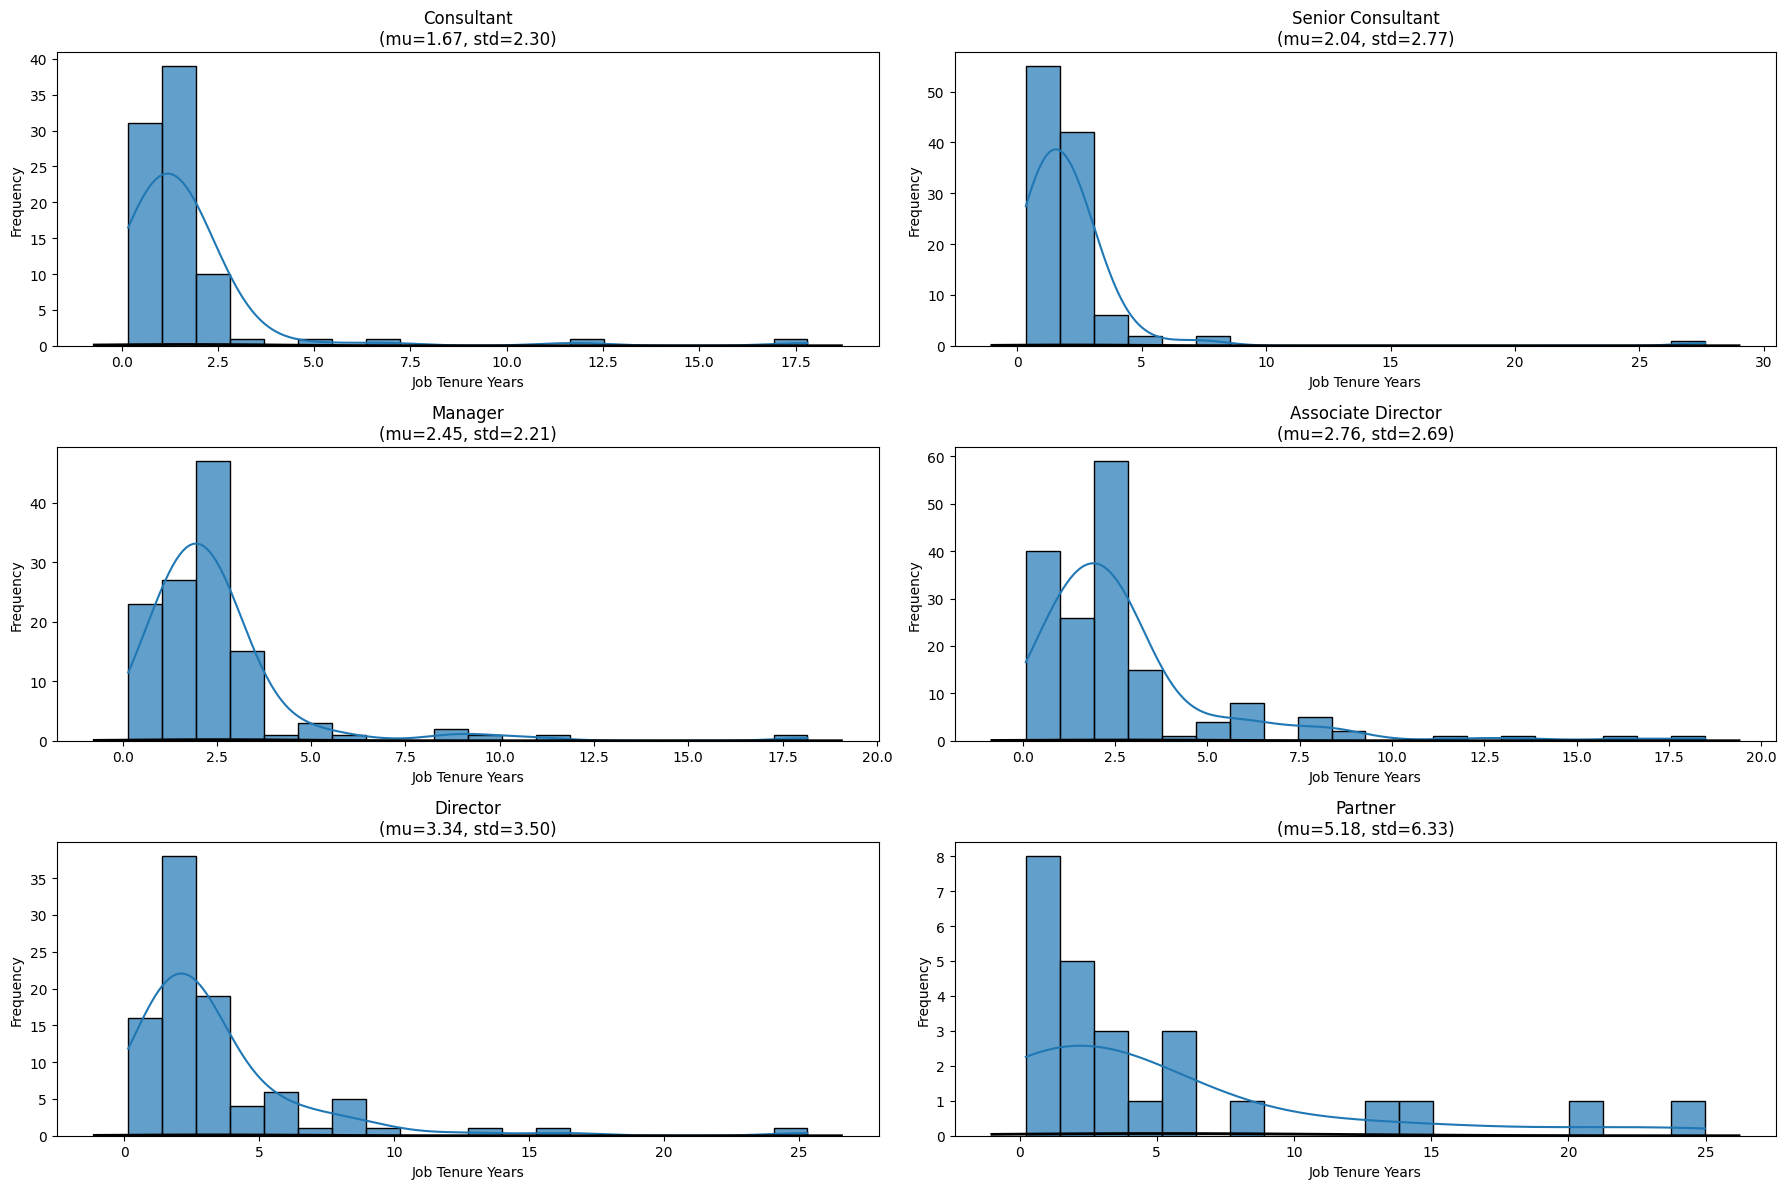

In [10]:

# List of job titles of interest
job_titles_of_interest = ['Consultant', 'Senior Consultant', 'Manager', 'Associate Director', 'Director', 'Partner']

# Filtering the DataFrame for the job titles of interest
filtered_df = df[df['jobTitle'].isin(job_titles_of_interest)]

# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
axes = axes.flatten()

# Loop through each job title of interest and plot the distribution
for i, title in enumerate(job_titles_of_interest):
    ax = axes[i]
    title_df = filtered_df[filtered_df['jobTitle'] == title]

    sns.histplot(title_df['jobTenureYears'], kde=True, bins=20, edgecolor='black', alpha=0.7, ax=ax)

    # Fit a normal distribution and plot it
    mu, std = stats.norm.fit(title_df['jobTenureYears'].dropna())
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)

    # Annotate the plot with the distribution type
    ax.set_title(f'{title}\n(mu={mu:.2f}, std={std:.2f})')
    ax.set_xlabel('Job Tenure Years')
    ax.set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()


In [11]:
for title in job_titles_of_interest:
    title_df = filtered_df[filtered_df['jobTitle'] == title]
    tenure_years = title_df['jobTenureYears'].dropna()

    # Calculate skewness and kurtosis
    skewness = stats.skew(tenure_years)
    kurtosis = stats.kurtosis(tenure_years)

    print(f'{title}: Skewness = {skewness:.2f}, Kurtosis = {kurtosis:.2f}')


Consultant: Skewness = 5.14, Kurtosis = 29.97
Senior Consultant: Skewness = 7.41, Kurtosis = 64.71
Manager: Skewness = 4.08, Kurtosis = 22.04
Associate Director: Skewness = 2.99, Kurtosis = 11.52
Director: Skewness = 3.55, Kurtosis = 16.65
Partner: Skewness = 1.84, Kurtosis = 2.53


# Created the EDA Reports on the Profile and Personnel datasets

In [23]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport



profilesprofile = ProfileReport(profiles)

df2 = df.drop([
    'linkedinProfileUrl', 'email', 'linkedinProfile', 'description', 'headline', 'imgUrl',
    'firstName', 'lastName', 'subscribers', 'connectionDegree', 'vmid', 'userId',
    'linkedinSalesNavigatorUrl', 'connectionsCount', 'connectionsUrl', 'mutualConnectionsUrl',
    'isOpenLink', 'isOpenToWork', 'isHiring', 'companyUrl', 'jobIsCurrent', 'jobDescription',
    'companyUrl2', 'jobDescription2', 'jobLocation2', 'jobIsCurrent2', 'jobDuration2',
    'schoolDegree', 'school2', 'baseUrl', 'profileId', 'timestamp', 'professionalEmail',
    'recordId', 'schoolDescription', 'website', 'schoolDescription2', 'mail', 'screenshot',
    'companyLinkedInUrl', 'mutualConnectionsText', 'connectedOn', 'birthday'
], axis=1)


dataprofile = ProfileReport(df2)



profilesprofile.to_file("Role_profile_report.html")
dataprofile.to_file("TechGroup_profile_report.html")

output_file = "/content/drive/MyDrive/Colab Notebooks/Matt/Role_profile_report.html"
output_file2 = "/content/drive/MyDrive/Colab Notebooks/Matt/TechGroup_profile_report.html"
profilesprofile.to_file(output_file)
dataprofile.to_file(output_file2)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=c798c2b312ecf8f4483f8a62823cda5073a3b3a203b33c0b80a0ddcdc4ac4771
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Broken Code and Brokener Dreams


In [ ]:
# code works might need
def get_profile_by_full_name(df):
    # Prompt user for input
    full_name = input("Enter the full name: ").strip()

    # Find the row corresponding to the full name
    matched_row = df[df['fullName'] == full_name]

    if matched_row.empty:
        print(f"No matching profile found for the name: {full_name}")
        return None
    else:
        matched_profile = matched_row['matchedProfile'].iloc[0]
        job_title = matched_profile.get('jobTitle')
        job_tenure_category = matched_profile.get('jobTenureCategory')
        print(f"Matched Profile for {full_name}:")
        print(f"Job Title: {job_title}")
        print(f"Job Tenure Category: {job_tenure_category}")
        return {'jobTitle': job_title, 'jobTenureCategory': job_tenure_category}

# Example usage
matched_profile = get_profile_by_full_name(df)
print(matched_profile)

In [ ]:
# Expanded mapping of common degree names to categories
degree_mapping = {
    'Bachelor': ['BSc', 'BA', 'BE', 'BEng', 'BS', 'BBA', 'BCom', 'BArch', 'BTech', 'Bachelor'],
    'Master': ['MSc', 'MA', 'MBA', 'MEng', 'MS', 'MPhil', 'MRes', 'MFA', 'MPA', 'MHA', 'MPH', 'LLM', 'Master'],
    'PhD': ['PhD', 'Doctorate', 'DPhil', 'EdD', 'DBA', 'DSc', 'JD', 'MD', 'DO'],
    'Associate': ['Associate', 'AS', 'AA', 'AAS'],
    'Diploma': ['Diploma', 'Certificate', 'Cert'],
    'High School': ['High School', 'Secondary', 'HSC', 'GCE', 'GED', 'A-Level', 'O-Level', 'SSC']
}

# Expanded mapping of degree fields to categories
field_mapping = {
    'Business': ['Business', 'Commerce', 'MBA', 'Management', 'Finance', 'Accounting', 'Marketing', 'Economics', 'HR', 'Human Resources'],
    'Data': ['Data', 'Analytics', 'Statistics', 'Big Data', 'Data Science', 'Data Analysis'],
    'IT': ['IT', 'Information Technology', 'Computer Science', 'CS', 'Software Engineering', 'Information Systems', 'Cybersecurity'],
    'Engineering': ['Engineering', 'Mechanical', 'Electrical', 'Civil', 'Chemical', 'Aerospace', 'Biomedical', 'Industrial', 'Environmental'],
    'Science': ['Biology', 'Physics', 'Chemistry', 'Science', 'Biochemistry', 'Environmental Science', 'Earth Science', 'Mathematics', 'Geology', 'Astronomy'],
    'Arts': ['Arts', 'Humanities', 'History', 'Philosophy', 'Literature', 'Linguistics', 'Fine Arts', 'Performing Arts'],
    'Health': ['Health', 'Medicine', 'Nursing', 'Pharmacy', 'Public Health', 'Dentistry', 'Veterinary', 'Physical Therapy', 'Occupational Therapy', 'Healthcare Administration'],
    'Law': ['Law', 'Legal', 'Jurisprudence', 'LLB', 'LLM']
}

# Function to categorize degree types
def categorize_degree(degree):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in degree_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to categorize degree fields
def categorize_field(degree):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in field_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to extract dates from the job date range
def extract_job_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].split('·')[0].strip() if len(dates) > 1 else 'Present'
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    if end_date_str == 'Present':
        end_date = datetime.now()
    else:
        try:
            end_date = datetime.strptime(end_date_str, '%b %Y')
        except ValueError:
            end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Function to calculate the tenure in years as a floating-point number
def calculate_tenure(start_date, end_date):
    if pd.isna(start_date):
        return None
    if pd.isna(end_date):
        end_date = datetime.now()
    duration_in_days = (end_date - start_date).days
    duration_in_months = duration_in_days / 30.44  # Average days per month
    duration_in_years = duration_in_months / 12
    return round(duration_in_years, 2)

# Load your dataset
df = df

# Apply the functions to the DataFrame
df['jobStartDate'], df['jobEndDate'] = zip(*df['jobDateRange'].apply(extract_job_dates))
df['jobTenureYears'] = df.apply(lambda row: calculate_tenure(row['jobStartDate'], row['jobEndDate']), axis=1)

# Calculate dynamic thresholds based on percentiles
percentiles = df['jobTenureYears'].quantile([0.33, 0.66]).values
junior_threshold = percentiles[0]
mid_level_threshold = percentiles[1]

# Function to categorize the tenure dynamically
def categorize_tenure(tenure_years):
    if pd.isna(tenure_years):
        return None
    if tenure_years < junior_threshold:
        return 'Junior'
    elif junior_threshold <= tenure_years < mid_level_threshold:
        return 'Mid-level'
    else:
        return 'Senior'

# Apply the dynamic categorization
df['jobTenureCategory'] = df['jobTenureYears'].apply(categorize_tenure)

# Apply the degree categorization functions
df['degreeCategory'] = df['schoolDegree'].apply(categorize_degree)
df['degreeCategory2'] = df['schoolDegree2'].apply(categorize_degree)
df['fieldCategory'] = df['schoolDegree'].apply(categorize_field)
df['fieldCategory2'] = df['schoolDegree2'].apply(categorize_field)

# Function to summarize the groups
def summarize_group(group):
    # Extract unique skills
    skills = list(set(group[['skill1', 'skill2', 'skill3', 'skill4', 'skill5', 'skill6']].values.ravel()))
    skills = [skill for skill in skills if pd.notna(skill)]

    # Sum endorsements for each skill
    endorsements = {
        'skill1': group['endorsement1'].sum(),
        'skill2': group['endorsement2'].sum(),
        'skill3': group['endorsement3'].sum(),
        'skill4': group['endorsement4'].sum(),
        'skill5': group['endorsement5'].sum(),
        'skill6': group['endorsement6'].sum()
    }

    # Extract unique degree types and fields
    degrees = list(set(group[['degreeCategory', 'degreeCategory2']].values.ravel()))
    degrees = [degree for degree in degrees if pd.notna(degree)]
    fields = list(set(group[['fieldCategory', 'fieldCategory2']].values.ravel()))
    fields = [field for field in fields if pd.notna(field)]

    summary = {
        'average_tenure_years': group['jobTenureYears'].mean(),
        'min_tenure_years': group['jobTenureYears'].min(),
        'max_tenure_years': group['jobTenureYears'].max(),
        'skills': skills,
        'endorsements': endorsements,
        'degrees': degrees,
        'fields': fields,
        'locations': group['jobLocation'].unique().tolist(),
        'companies': group['company'].unique().tolist(),
    }
    return pd.Series(summary)

# Group by job title and tenure category
grouped = df.groupby(['jobTitle', 'jobTenureCategory'])

# Apply the summary function to each group
profiles = grouped.apply(summarize_group).reset_index()

# Display the profiles
#print(profiles)




In [ ]:
# Expanded mapping of common degree names to categories
degree_mapping = {
    'Bachelor': ['BSc', 'BA', 'BE', 'BEng', 'BS', 'BBA', 'BCom', 'BArch', 'BTech', 'Bachelor'],
    'Master': ['MSc', 'MA', 'MBA', 'MEng', 'MS', 'MPhil', 'MRes', 'MFA', 'MPA', 'MHA', 'MPH', 'LLM', 'Master'],
    'PhD': ['PhD', 'Doctorate', 'DPhil', 'EdD', 'DBA', 'DSc', 'JD', 'MD', 'DO'],
    'Associate': ['Associate', 'AS', 'AA', 'AAS'],
    'Diploma': ['Diploma', 'Certificate', 'Cert'],
    'High School': ['High School', 'Secondary', 'HSC', 'GCE', 'GED', 'A-Level', 'O-Level', 'SSC']
}

# Expanded mapping of degree fields to categories
field_mapping = {
    'Business': ['Business', 'Commerce', 'MBA', 'Management', 'Finance', 'Accounting', 'Marketing', 'Economics', 'HR', 'Human Resources'],
    'Data': ['Data', 'Analytics', 'Statistics', 'Big Data', 'Data Science', 'Data Analysis'],
    'IT': ['IT', 'Information Technology', 'Computer Science', 'CS', 'Software Engineering', 'Information Systems', 'Cybersecurity'],
    'Engineering': ['Engineering', 'Mechanical', 'Electrical', 'Civil', 'Chemical', 'Aerospace', 'Biomedical', 'Industrial', 'Environmental'],
    'Science': ['Biology', 'Physics', 'Chemistry', 'Science', 'Biochemistry', 'Environmental Science', 'Earth Science', 'Mathematics', 'Geology', 'Astronomy'],
    'Arts': ['Arts', 'Humanities', 'History', 'Philosophy', 'Literature', 'Linguistics', 'Fine Arts', 'Performing Arts'],
    'Health': ['Health', 'Medicine', 'Nursing', 'Pharmacy', 'Public Health', 'Dentistry', 'Veterinary', 'Physical Therapy', 'Occupational Therapy', 'Healthcare Administration'],
    'Law': ['Law', 'Legal', 'Jurisprudence', 'LLB', 'LLM']
}

# Function to update mappings dynamically
def update_mappings(degree_mapping=None, field_mapping=None):
    if degree_mapping:
        for category, keywords in degree_mapping.items():
            if category in degree_mapping:
                degree_mapping[category].extend(keywords)
            else:
                degree_mapping[category] = keywords
    if field_mapping:
        for category, keywords in field_mapping.items():
            if category in field_mapping:
                field_mapping[category].extend(keywords)
            else:
                field_mapping[category] = keywords

# Function to categorize degree types
def categorize_degree(degree, degree_mapping):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in degree_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to categorize degree fields
def categorize_field(degree, field_mapping):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in field_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to extract dates from the job date range
def extract_job_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].split('·')[0].strip() if len(dates) > 1 else 'Present'
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    if end_date_str == 'Present':
        end_date = datetime.now()
    else:
        try:
            end_date = datetime.strptime(end_date_str, '%b %Y')
        except ValueError:
            end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Function to calculate the tenure in years as a floating-point number
def calculate_tenure(start_date, end_date):
    if pd.isna(start_date):
        return None
    if pd.isna(end_date):
        end_date = datetime.now()
    duration_in_days = (end_date - start_date).days
    duration_in_months = duration_in_days / 30.44  # Average days per month
    duration_in_years = duration_in_months / 12
    return round(duration_in_years, 2)

# Load your# dataset
#df = pd.read_csv('your_data.csv')

# Apply the functions to the DataFrame
df['jobStartDate'], df['jobEndDate'] = zip(*df['jobDateRange'].apply(extract_job_dates))
df['jobTenureYears'] = df.apply(lambda row: calculate_tenure(row['jobStartDate'], row['jobEndDate']), axis=1)

# Calculate dynamic thresholds based on percentiles
percentiles = df['jobTenureYears'].quantile([0.33, 0.66]).values
junior_threshold = percentiles[0]
mid_level_threshold = percentiles[1]

# Function to categorize the tenure dynamically
def categorize_tenure(tenure_years):
    if pd.isna(tenure_years):
        return None
    if tenure_years < junior_threshold:
        return 'Junior'
    elif junior_threshold <= tenure_years < mid_level_threshold:
        return 'Mid-level'
    else:
        return 'Senior'

# Apply the dynamic categorization
df['jobTenureCategory'] = df['jobTenureYears'].apply(categorize_tenure)

# Apply the degree categorization functions
df['degreeCategory'] = df['schoolDegree'].apply(categorize_degree, args=(degree_mapping,))
df['degreeCategory2'] = df['schoolDegree2'].apply(categorize_degree, args=(degree_mapping,))
df['fieldCategory'] = df['schoolDegree'].apply(categorize_field, args=(field_mapping,))
df['fieldCategory2'] = df['schoolDegree2'].apply(categorize_field, args=(field_mapping,))

# Function to summarize the groups
def summarize_group(group):
    # Extract unique skills
    skills = list(set(group[['skill1', 'skill2', 'skill3', 'skill4', 'skill5', 'skill6']].values.ravel()))
    skills = [skill for skill in skills if pd.notna(skill)]

    # Sum endorsements for each skill
    endorsements = {
        'skill1': group['endorsement1'].sum(),
        'skill2': group['endorsement2'].sum(),
        'skill3': group['endorsement3'].sum(),
        'skill4': group['endorsement4'].sum(),
        'skill5': group['endorsement5'].sum(),
        'skill6': group['endorsement6'].sum()
    }

    # Extract unique degree types and fields
    degrees = list(set(group[['degreeCategory', 'degreeCategory2']].values.ravel()))
    degrees = [degree for degree in degrees if pd.notna(degree)]
    fields = list(set(group[['fieldCategory', 'fieldCategory2']].values.ravel()))
    fields = [field for field in fields if pd.notna(field)]

    summary = {
        'average_tenure_years': group['jobTenureYears'].mean(),
        'min_tenure_years': group['jobTenureYears'].min(),
        'max_tenure_years': group['jobTenureYears'].max(),
        'skills': skills,
        'endorsements': endorsements,
        'degrees': degrees,
        'fields': fields,
        'locations': group['jobLocation'].unique().tolist(),
        'companies': group['company'].unique().tolist(),
    }
    return pd.Series(summary)

# Group by job title and tenure category
grouped = df.groupby(['jobTitle', 'jobTenureCategory'])

# Apply the summary function to each group
profiles = grouped.apply(summarize_group).reset_index()

# Function to display expected profiles for each tenure of each unique title
def display_expected_profiles(profiles):
    for _, row in profiles.iterrows():
        print(f"Job Title: {row['jobTitle']}")
        print(f"Tenure Category: {row['jobTenureCategory']}")
        print(f"Average Tenure Years: {row['average_tenure_years']:.2f}")
        print(f"Min Tenure Years: {row['min_tenure_years']:.2f}")
        print(f"Max Tenure Years: {row['max_tenure_years']:.2f}")
        print(f"Skills: {', '.join(row['skills'])}")
        print(f"Endorsements: {row['endorsements']}")
        print(f"Degrees: {', '.join(row['degrees'])}")
        print(f"Fields: {', '.join(row['fields'])}")
        #print(f"Locations: {', '.join(row['locations'])}")
        print(f"Companies: {', '.join(row['companies'])}")
        print("-" * 40)

# Display the expected profiles
display_expected_profiles(profiles)

In [ ]:
# Function to convert date range to start and end dates
def extract_dates(date_range):
    if pd.isna(date_range):
        return None, None
    date_part = date_range.split(' · ')[0]
    start_date_str, end_date_str = date_part.split(' - ')
    start_date = datetime.strptime(start_date_str, '%b %Y')
    end_date = datetime.now() if end_date_str == 'Present' else datetime.strptime(end_date_str, '%b %Y')
    return start_date, end_date

# Function to calculate job duration in years as a floating point number
def calculate_job_duration_in_years(start_date, end_date):
    if pd.isna(start_date) or pd.isna(end_date):
        return None
    duration_in_days = (end_date - start_date).days
    duration_in_months = duration_in_days / 30.44  # Average days per month
    duration_in_years = duration_in_months / 12
    return round(duration_in_years, 2)

# Extract and calculate durations for each job
df['jobStartedSince'] = df['jobDateRange'].apply(lambda x: extract_dates(x)[0])
df['jobEndedSince'] = df['jobDateRange'].apply(lambda x: extract_dates(x)[1])

df['jobStartedSince2'] = df['jobDateRange2'].apply(lambda x: extract_dates(x)[0])
df['jobEndedSince2'] = df['jobDateRange2'].apply(lambda x: extract_dates(x)[1])

# Calculate durations
df['jobDurationYears'] = df.apply(lambda row: calculate_job_duration_in_years(row['jobStartedSince'], row['jobEndedSince']), axis=1)
df['jobDurationYears2'] = df.apply(lambda row: calculate_job_duration_in_years(row['jobStartedSince2'], row['jobEndedSince2']), axis=1)

# Display results
print(df[['jobStartedSince', 'jobEndedSince', 'jobDurationYears']])
print(df[['jobStartedSince2', 'jobEndedSince2', 'jobDurationYears2']])

ValueError: time data '2021' does not match format '%b %Y'

In [ ]:
# Function to convert date range to start and end dates
def extract_education_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    if len(dates) == 2:
        start_date_str, end_date_str = dates
        try:
            start_date = datetime.strptime(start_date_str, '%b %Y')
        except ValueError:
            start_date = datetime.strptime(start_date_str, '%Y')
        if end_date_str == 'Present':
            end_date = datetime.now()
        else:
            try:
                end_date = datetime.strptime(end_date_str, '%b %Y')
            except ValueError:
                end_date = datetime.strptime(end_date_str, '%Y')
    else:
        try:
            start_date = datetime.strptime(dates[0], '%b %Y')
        except ValueError:
            start_date = datetime.strptime(dates[0], '%Y')
        end_date = None
    return start_date, end_date

# Function to calculate time since graduation in years as a floating point number
def calculate_time_since_graduation(end_date):
    if pd.isna(end_date):
        return None
    duration_in_days = (datetime.now() - end_date).days
    duration_in_months = duration_in_days / 30.44  # Average days per month
    duration_in_years = duration_in_months / 12
    return round(duration_in_years, 2)

# Extract and calculate dates for each education
df['schoolStartDate'], df['schoolEndDate'] = zip(*df['schoolDateRange'].apply(extract_education_dates))
df['schoolStartDate2'], df['schoolEndDate2'] = zip(*df['schoolDateRange2'].apply(extract_education_dates))

# Define a list of valid tertiary education degrees
tertiary_degrees = ['Associate', 'Bachelor', 'Master', 'Doctor', 'MSc', 'PhD', 'MBA', 'BSc', 'BE', 'BEng']

# Function to check if the degree is tertiary
def is_tertiary_education(degree):
    if pd.isna(degree):
        return False
    return any(tertiary_degree in degree for tertiary_degree in tertiary_degrees)

# Filter only tertiary education dates
df['isTertiary1'] = df['schoolDegree'].apply(is_tertiary_education)
df['isTertiary2'] = df['schoolDegree2'].apply(is_tertiary_education)

# Select only the end dates of tertiary education
df['tertiaryEndDate1'] = df.apply(lambda row: row['schoolEndDate'] if row['isTertiary1'] else pd.NaT, axis=1)
df['tertiaryEndDate2'] = df.apply(lambda row: row['schoolEndDate2'] if row['isTertiary2'] else pd.NaT, axis=1)

# Find the earliest graduation date among tertiary education
df['earliestTertiaryEndDate'] = df[['tertiaryEndDate1', 'tertiaryEndDate2']].min(axis=1)

# Calculate time since graduation
df['timeSinceGraduationYears'] = df['earliestTertiaryEndDate'].apply(calculate_time_since_graduation)

# Display results
print(df[['schoolDegree', 'schoolEndDate', 'schoolDegree2', 'schoolEndDate2', 'earliestTertiaryEndDate', 'timeSinceGraduationYears']])

ValueError: time data 'Jul-04' does not match format '%Y'

In [ ]:
import pandas as pd
from datetime import datetime

# Function to extract dates from the education date range
def extract_education_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].strip() if len(dates) > 1 else start_date_str
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    try:
        end_date = datetime.strptime(end_date_str, '%b %Y')
    except ValueError:
        end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Apply the function to extract education dates
df['schoolStartDate'], df['schoolEndDate'] = zip(*df['schoolDateRange'].apply(extract_education_dates))
df['schoolStartDate2'], df['schoolEndDate2'] = zip(*df['schoolDateRange2'].apply(extract_education_dates))

# Define a list of valid tertiary education degrees
tertiary_degrees = ['Bachelor', 'Master', 'PhD', 'Associate', 'Diploma']

# Function to calculate total working experience
def calculate_total_experience(df):
    df['undergraduate_graduation_date'] = df.apply(lambda row: row['schoolEndDate'] if row['degreeCategory'] == 'Bachelor' else row['schoolEndDate2'] if row['degreeCategory2'] == 'Bachelor' else None, axis=1)
    df['undergraduate_graduation_date'] = pd.to_datetime(df['undergraduate_graduation_date'], errors='coerce')
    df['total_experience_years'] = (datetime.now() - df['undergraduate_graduation_date']).dt.days / 365.25
    return df

# Apply the function to the DataFrame
df = calculate_total_experience(df)

# Calculate dynamic thresholds based on percentiles
percentiles = df['jobTenureYears'].quantile([0.33, 0.66]).values
junior_threshold = percentiles[0]
mid_level_threshold = percentiles[1]

# Function to categorize the tenure dynamically
def categorize_tenure(tenure_years):
    if pd.isna(tenure_years):
        return None
    if tenure_years < junior_threshold:
        return 'Junior'
    elif junior_threshold <= tenure_years < mid_level_threshold:
        return 'Mid-level'
    else:
        return 'Senior'

# Apply the dynamic categorization
df['jobTenureCategory'] = df['jobTenureYears'].apply(categorize_tenure)

# Function to collect user input and assign tenure
def input_and_assign_tenure(profiles):
    while True:
        user_input = input(
            "Enter your data in the following format (separate each field with a comma):\n"
            "Job Title, Job Date Range, First Degree, Undergraduate Graduation Date (e.g., 'Feb 2017' or '2017'), "
            "Second Degree (optional), "
            "First Degree Field, Second Degree Field (optional), "
            "Skill 1 (optional), Skill 2 (optional), Skill 3 (optional), Skill 4 (optional), Skill 5 (optional), Skill 6 (optional), "
            "Endorsements for Skill 1 (optional), Endorsements for Skill 2 (optional), Endorsements for Skill 3 (optional), "
            "Endorsements for Skill 4 (optional), Endorsements for Skill 5 (optional), Endorsements for Skill 6 (optional):\n"
        ).split(',')

        if len(user_input) < 4:
            print("Please enter at least Job Title, Job Date Range, First Degree, and Undergraduate Graduation Date.")
            continue

        job_title = user_input[0].strip()
        job_date_range = user_input[1].strip()
        degree1 = user_input[2].strip()
        undergrad_grad_date_str = user_input[3].strip()
        degree2 = user_input[4].strip() if len(user_input) > 4 else ''
        field1 = user_input[5].strip() if len(user_input) > 5 else ''
        field2 = user_input[6].strip() if len(user_input) > 6 else ''

        # Optional fields
        skill1 = user_input[7].strip() if len(user_input) > 7 else ''
        skill2 = user_input[8].strip() if len(user_input) > 8 else ''
        skill3 = user_input[9].strip() if len(user_input) > 9 else ''
        skill4 = user_input[10].strip() if len(user_input) > 10 else ''
        skill5 = user_input[11].strip() if len(user_input) > 11 else ''
        skill6 = user_input[12].strip() if len(user_input) > 12 else ''

        endorsement1 = user_input[13].strip() if len(user_input) > 13 else '0'
        endorsement2 = user_input[14].strip() if len(user_input) > 14 else '0'
        endorsement3 = user_input[15].strip() if len(user_input) > 15 else '0'
        endorsement4 = user_input[16].strip() if len(user_input) > 16 else '0'
        endorsement5 = user_input[17].strip() if len(user_input) > 17 else '0'
        endorsement6 = user_input[18].strip() if len(user_input) > 18 else '0'

        # Convert endorsements to integers, default to 0 if empty
        endorsement1 = int(endorsement1) if endorsement1.isdigit() else 0
        endorsement2 = int(endorsement2) if endorsement2.isdigit() else 0
        endorsement3 = int(endorsement3) if endorsement3.isdigit() else 0
        endorsement4 = int(endorsement4) if endorsement4.isdigit() else 0
        endorsement5 = int(endorsement5) if endorsement5.isdigit() else 0
        endorsement6 = int(endorsement6) if endorsement6.isdigit() else 0

        start_date, end_date = extract_job_dates(job_date_range)

        tenure_years = calculate_tenure(start_date, end_date)
        tenure_category = categorize_tenure(tenure_years)

        print(f"\nCalculated Tenure Years: {tenure_years}")
        print(f"Assigned Tenure Category: {tenure_category}")

        # Parse the undergraduate graduation date
        try:
            undergrad_grad_date = datetime.strptime(undergrad_grad_date_str, '%b %Y')
        except ValueError:
            undergrad_grad_date = datetime.strptime(undergrad_grad_date_str, '%Y')

        total_experience_years = (datetime.now() - undergrad_grad_date).days / 365.25

        print(f"Total Experience Years: {total_experience_years:.2f}")

        user_profile = {
            'job_title': job_title,
            'job_date_range': job_date_range,
            'start_date': start_date,
            'end_date': end_date,
            'tenure_years': tenure_years,
            'tenure_category': tenure_category,
            'skills': [skill1, skill2, skill3, skill4, skill5, skill6],
            'endorsements': {
                'skill1': endorsement1,
                'skill2': endorsement2,
                'skill3': endorsement3,
                'skill4': endorsement4,
                'skill5': endorsement5,
                'skill6': endorsement6
            },
            'degrees': [degree1, degree2],
            'fields': [field1, field2],
            'total_experience_years': total_experience_years
        }

        matching_profiles = profiles[(profiles['jobTitle'] == job_title) & (profiles['jobTenureCategory'] == tenure_category)]

        if not matching_profiles.empty:
            print("\nMatching Profile Found:")
            for _, row in matching_profiles.iterrows():
                print(f"Job Title: {row['jobTitle']}")
                print(f"Tenure Category: {row['jobTenureCategory']}")
                print(f"Average Tenure Years: {row['average_tenure_years']:.2f}")
                print(f"Min Tenure Years: {row['min_tenure_years']:.2f}")
                print(f"Max Tenure Years: {row['max_tenure_years']:.2f}")
                print(f"Skills: {', '.join(row['skills'])}")
                print(f"Endorsements: {row['endorsements']}")
                print(f"Degrees: {', '.join(row['degrees'])}")
                print(f"Fields: {', '.join(row['fields'])}")
                print(f"Locations: {', '.join(row['locations'])}")
                print(f"Companies: {', '.join(row['companies'])}")
                print("-" * 40)
        else:
            print("\nNo matching profile found.")

        return user_profile

# Example usage
user_profile = input_and_assign_tenure(df)
print(user_profile)



ValueError: time data 'Jul-04' does not match format '%Y'

In [ ]:
import pandas as pd
from datetime import datetime

# Expanded mapping of common degree names to categories
degree_mapping = {
    'Bachelor': ['BSc', 'BA', 'BE', 'BEng', 'BS', 'BBA', 'BCom', 'BArch', 'BTech', 'Bachelor'],
    'Master': ['MSc', 'MA', 'MBA', 'MEng', 'MS', 'MPhil', 'MRes', 'MFA', 'MPA', 'MHA', 'MPH', 'LLM', 'Master'],
    'PhD': ['PhD', 'Doctorate', 'DPhil', 'EdD', 'DBA', 'DSc', 'JD', 'MD', 'DO'],
    'Associate': ['Associate', 'AS', 'AA', 'AAS'],
    'Diploma': ['Diploma', 'Certificate', 'Cert'],
    'High School': ['High School', 'Secondary', 'HSC', 'GCE', 'GED', 'A-Level', 'O-Level', 'SSC']
}

# Expanded mapping of degree fields to categories
field_mapping = {
    'Business': ['Business', 'Commerce', 'MBA', 'Management', 'Finance', 'Accounting', 'Marketing', 'Economics', 'HR', 'Human Resources'],
    'Data': ['Data', 'Analytics', 'Statistics', 'Big Data', 'Data Science', 'Data Analysis'],
    'IT': ['IT', 'Information Technology', 'Computer Science', 'CS', 'Software Engineering', 'Information Systems', 'Cybersecurity'],
    'Engineering': ['Engineering', 'Mechanical', 'Electrical', 'Civil', 'Chemical', 'Aerospace', 'Biomedical', 'Industrial', 'Environmental'],
    'Science': ['Biology', 'Physics', 'Chemistry', 'Science', 'Biochemistry', 'Environmental Science', 'Earth Science', 'Mathematics', 'Geology', 'Astronomy'],
    'Arts': ['Arts', 'Humanities', 'History', 'Philosophy', 'Literature', 'Linguistics', 'Fine Arts', 'Performing Arts'],
    'Health': ['Health', 'Medicine', 'Nursing', 'Pharmacy', 'Public Health', 'Dentistry', 'Veterinary', 'Physical Therapy', 'Occupational Therapy', 'Healthcare Administration'],
    'Law': ['Law', 'Legal', 'Jurisprudence', 'LLB', 'LLM']
}

# Function to update mappings dynamically
def update_mappings(degree_mapping=None, field_mapping=None):
    if degree_mapping:
        for category, keywords in degree_mapping.items():
            if category in degree_mapping:
                degree_mapping[category].extend(keywords)
            else:
                degree_mapping[category] = keywords
    if field_mapping:
        for category, keywords in field_mapping.items():
            if category in field_mapping:
                field_mapping[category].extend(keywords)
            else:
                field_mapping[category] = keywords

# Function to categorize degree types
def categorize_degree(degree, degree_mapping):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in degree_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to categorize degree fields
def categorize_field(degree, field_mapping):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in field_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to extract dates from the job date range
def extract_job_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].split('·')[0].strip() if len(dates) > 1 else 'Present'
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    if end_date_str == 'Present':
        end_date = datetime.now()
    else:
        try:
            end_date = datetime.strptime(end_date_str, '%b %Y')
        except ValueError:
            end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Function to calculate the tenure in years as a floating-point number
def calculate_tenure(start_date, end_date):
    if pd.isna(start_date):
        return None
    if pd.isna(end_date):
        end_date = datetime.now()
    duration_in_days = (end_date - start_date).days
    duration_in_months = duration_in_days / 30.44  # Average days per month
    duration_in_years = duration_in_months / 12
    return round(duration_in_years, 2)

# Function to extract dates from the education date range
def extract_education_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].strip() if len(dates) > 1 else start_date_str
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    try:
        end_date = datetime.strptime(end_date_str, '%b %Y')
    except ValueError:
        end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Apply the function to extract education dates
df['schoolStartDate'], df['schoolEndDate'] = zip(*df['schoolDateRange'].apply(extract_education_dates))
df['schoolStartDate2'], df['schoolEndDate2'] = zip(*df['schoolDateRange2'].apply(extract_education_dates))

# Define a list of valid tertiary education degrees
tertiary_degrees = ['Bachelor', 'Master', 'PhD', 'Associate', 'Diploma']

# Define a list of valid tertiary education degrees
tertiary_degrees = ['Bachelor', 'Master', 'PhD', 'Associate', 'Diploma']

# Load your dataset
# df = pd.read_csv('your_data.csv')

# Apply the functions to the DataFrame
df['jobStartDate'], df['jobEndDate'] = zip(*df['jobDateRange'].apply(extract_job_dates))
df['jobTenureYears'] = df.apply(lambda row: calculate_tenure(row['jobStartDate'], row['jobEndDate']), axis=1)

# Calculate dynamic thresholds based on percentiles
percentiles = df['jobTenureYears'].quantile([0.33, 0.66]).values
junior_threshold = percentiles[0]
mid_level_threshold = percentiles[1]

# Function to categorize the tenure dynamically
def categorize_tenure(tenure_years):
    if pd.isna(tenure_years):
        return None
    if tenure_years < junior_threshold:
        return 'Junior'
    elif junior_threshold <= tenure_years < mid_level_threshold:
        return 'Mid-level'
    else:
        return 'Senior'

# Apply the dynamic categorization
df['jobTenureCategory'] = df['jobTenureYears'].apply(categorize_tenure)

# Apply the degree categorization functions
df['degreeCategory'] = df['schoolDegree'].apply(categorize_degree, args=(degree_mapping,))
df['degreeCategory2'] = df['schoolDegree2'].apply(categorize_degree, args=(degree_mapping,))
df['fieldCategory'] = df['schoolDegree'].apply(categorize_field, args=(field_mapping,))
df['fieldCategory2'] = df['schoolDegree2'].apply(categorize_field, args=(field_mapping,))

# Apply the function to extract education dates
df['schoolStartDate'], df['schoolEndDate'] = zip(*df['schoolDateRange'].apply(extract_education_dates))
df['schoolStartDate2'], df['schoolEndDate2'] = zip(*df['schoolDateRange2'].apply(extract_education_dates))

# Function to calculate total working experience
def calculate_total_experience(df):
    df['undergraduate_graduation_date'] = df.apply(lambda row: row['schoolEndDate'] if row['degreeCategory'] == 'Bachelor' else row['schoolEndDate2'] if row['degreeCategory2'] == 'Bachelor' else None, axis=1)
    df['undergraduate_graduation_date'] = pd.to_datetime(df['undergraduate_graduation_date'], errors='coerce')
    df['total_experience_years'] = (datetime.now() - df['undergraduate_graduation_date']).dt.days / 365.25
    return df

# Apply the function to the DataFrame
df = calculate_total_experience(df)

# Function to summarize the groups
def summarize_group(group):
    # Extract unique skills
    skills = list(set(group[['skill1', 'skill2', 'skill3', 'skill4', 'skill5', 'skill6']].values.ravel()))
    skills = [skill for skill in skills if pd.notna(skill)]

    # Sum endorsements for each skill
    endorsements = {
        'skill1': group['endorsement1'].sum(),
        'skill2': group['endorsement2'].sum(),
        'skill3': group['endorsement3'].sum(),
        'skill4': group['endorsement4'].sum(),
        'skill5': group['endorsement5'].sum(),
        'skill6': group['endorsement6'].sum()
    }

    # Extract unique degree types and fields
    degrees = list(set(group[['degreeCategory', 'degreeCategory2']].values.ravel()))
    degrees = [degree for degree in degrees if pd.notna(degree)]
    fields = list(set(group[['fieldCategory', 'fieldCategory2']].values.ravel()))
    fields = [field for field in fields if pd.notna(field)]

    # Calculate average total experience
    average_total_experience = group['total_experience_years'].mean()

    summary = {
        'average_tenure_years': group['jobTenureYears'].mean(),
        'min_tenure_years': group['jobTenureYears'].min(),
        'max_tenure_years': group['jobTenureYears'].max(),
        'average_total_experience_years': average_total_experience,
        'skills': skills,
        'endorsements': endorsements,
        'degrees': degrees,
        'fields': fields,
        'locations': group['jobLocation'].unique().tolist(),
        'companies': group['company'].unique().tolist(),
    }
    return pd.Series(summary)

# Group by job title and tenure category
grouped = df.groupby(['jobTitle', 'jobTenureCategory'])

# Apply the summary function to each group
profiles = grouped.apply(summarize_group).reset_index()

# Function to display expected profiles for each tenure of each unique title
def display_expected_profiles(profiles):
    for _, row in profiles.iterrows():
        print(f"Job Title: {row['jobTitle']}")
        print(f"Tenure Category: {row['jobTenureCategory']}")
        print(f"Average Tenure Years: {row['average_tenure_years']:.2f}")
        print(f"Min Tenure Years: {row['min_tenure_years']:.2f}")
        print(f"Max Tenure Years: {row['max_tenure_years']:.2f}")
        print(f"Average Total Experience Years: {row['average_total_experience_years']:.2f}")
        print(f"Skills: {', '.join(row['skills'])}")
        print(f"Endorsements: {row['endorsements']}")
        print(f"Degrees: {', '.join(row['degrees'])}")
        print(f"Fields: {', '.join(row['fields'])}")
        #print(f"Locations: {', '.join(row['locations'])}")
        print(f"Companies: {', '.join(row['companies'])}")
        print("-" * 40)

# Display the expected profiles
display_expected_profiles(profiles)

# Function to collect user input and assign tenure
def input_and_assign_tenure(profiles):
    while True:
        user_input = input(
            "Enter your data in the following format (separate each field with a comma):\n"
            "Job Title, Job Date Range, Undergraduate Degree, Undergraduate Graduation Date (e.g., 'Feb 2017' or '2017'), "
            "Second Degree (optional), "
            "First Degree Field, Second Degree Field (optional), "
            "Skill 1 (optional), Skill 2 (optional), Skill 3 (optional), Skill 4 (optional), Skill 5 (optional), Skill 6 (optional), "
            "Endorsements for Skill 1 (optional), Endorsements for Skill 2 (optional), Endorsements for Skill 3 (optional), "
            "Endorsements for Skill 4 (optional), Endorsements for Skill 5 (optional), Endorsements for Skill 6 (optional):\n"
        ).split(',')

        if len(user_input) < 4:
            print("Please enter at least Job Title, Job Date Range, Undergraduate Degree, and Undergraduate Graduation Date.")
            continue

        job_title = user_input[0].strip()
        job_date_range = user_input[1].strip()
        degree1 = user_input[2].strip()
        undergrad_grad_date_str = user_input[3].strip()
        degree2 = user_input[4].strip() if len(user_input) > 4 else ''
        field1 = user_input[5].strip() if len(user_input) > 5 else ''
        field2 = user_input[6].strip() if len(user_input) > 6 else ''

        # Optional fields
        skill1 = user_input[7].strip() if len(user_input) > 7 else ''
        skill2 = user_input[8].strip() if len(user_input) > 8 else ''
        skill3 = user_input[9].strip() if len(user_input) > 9 else ''
        skill4 = user_input[10].strip() if len(user_input) > 10 else ''
        skill5 = user_input[11].strip() if len(user_input) > 11 else ''
        skill6 = user_input[12].strip() if len(user_input) > 12 else ''

        endorsement1 = user_input[13].strip() if len(user_input) > 13 else '0'
        endorsement2 = user_input[14].strip() if len(user_input) > 14 else '0'
        endorsement3 = user_input[15].strip() if len(user_input) > 15 else '0'
        endorsement4 = user_input[16].strip() if len(user_input) > 16 else '0'
        endorsement5 = user_input[17].strip() if len(user_input) > 17 else '0'
        endorsement6 = user_input[18].strip() if len(user_input) > 18 else '0'

        # Convert endorsements to integers, default to 0 if empty
        endorsement1 = int(endorsement1) if endorsement1.isdigit() else 0
        endorsement2 = int(endorsement2) if endorsement2.isdigit() else 0
        endorsement3 = int(endorsement3) if endorsement3.isdigit() else 0
        endorsement4 = int(endorsement4) if endorsement4.isdigit() else 0
        endorsement5 = int(endorsement5) if endorsement5.isdigit() else 0
        endorsement6 = int(endorsement6) if endorsement6.isdigit() else 0

        start_date, end_date = extract_job_dates(job_date_range)

        tenure_years = calculate_tenure(start_date, end_date)
        tenure_category = categorize_tenure(tenure_years)

        print(f"\nCalculated Tenure Years: {tenure_years}")
        print(f"Assigned Tenure Category: {tenure_category}")

        # Parse the undergraduate graduation date
        try:
            undergrad_grad_date = datetime.strptime(undergrad_grad_date_str, '%b %Y')
        except ValueError:
            undergrad_grad_date = datetime.strptime(undergrad_grad_date_str, '%Y')

        total_experience_years = (datetime.now() - undergrad_grad_date).days / 365.25

        print(f"Total Experience Years: {total_experience_years:.2f}")

        user_profile = {
            'job_title': job_title,
            'job_date_range': job_date_range,
            'start_date': start_date,
            'end_date': end_date,
            'tenure_years': tenure_years,
            'tenure_category': tenure_category,
            'skills': [skill1, skill2, skill3, skill4, skill5, skill6],
            'endorsements': {
                'skill1': endorsement1,
                'skill2': endorsement2,
                'skill3': endorsement3,
                'skill4': endorsement4,
                'skill5': endorsement5,
                'skill6': endorsement6
            },
            'degrees': [degree1, degree2],
            'fields': [field1, field2],
            'total_experience_years': total_experience_years
        }

        matching_profiles = profiles[(profiles['jobTitle'] == job_title) & (profiles['jobTenureCategory'] == tenure_category)]

        if not matching_profiles.empty:
            print("\nMatching Profile Found:")
            for _, row in matching_profiles.iterrows():
                print(f"Job Title: {row['jobTitle']}")
                print(f"Tenure Category: {row['jobTenureCategory']}")
                print(f"Average Tenure Years: {row['average_tenure_years']:.2f}")
                print(f"Min Tenure Years: {row['min_tenure_years']:.2f}")
                print(f"Max Tenure Years: {row['max_tenure_years']:.2f}")
                print(f"Average Total Experience Years: {row['average_total_experience_years']:.2f}")
                print(f"Skills: {', '.join(row['skills'])}")
                print(f"Endorsements: {row['endorsements']}")
                print(f"Degrees: {', '.join(row['degrees'])}")
                print(f"Fields: {', '.join(row['fields'])}")
                print(f"Locations: {', '.join(row['locations'])}")
                print(f"Companies: {', '.join(row['companies'])}")
                print("-" * 40)
        else:
            print("\nNo matching profile found.")

        return user_profile

# Example usage
user_profile = input_and_assign_tenure(profiles)
print(user_profile)


ValueError: time data 'Jul-04' does not match format '%Y'

In [ ]:
import pandas as pd
from datetime import datetime

# Expanded mapping of common degree names to categories
degree_mapping = {
    'Bachelor': ['BSc', 'BA', 'BE', 'BEng', 'BS', 'BBA', 'BCom', 'BArch', 'BTech', 'Bachelor'],
    'Master': ['MSc', 'MA', 'MBA', 'MEng', 'MS', 'MPhil', 'MRes', 'MFA', 'MPA', 'MHA', 'MPH', 'LLM', 'Master'],
    'PhD': ['PhD', 'Doctorate', 'DPhil', 'EdD', 'DBA', 'DSc', 'JD', 'MD', 'DO'],
    'Associate': ['Associate', 'AS', 'AA', 'AAS'],
    'Diploma': ['Diploma', 'Certificate', 'Cert'],
    'High School': ['High School', 'Secondary', 'HSC', 'GCE', 'GED', 'A-Level', 'O-Level', 'SSC']
}

# Expanded mapping of degree fields to categories
field_mapping = {
    'Business': ['Business', 'Commerce', 'MBA', 'Management', 'Finance', 'Accounting', 'Marketing', 'Economics', 'HR', 'Human Resources'],
    'Data': ['Data', 'Analytics', 'Statistics', 'Big Data', 'Data Science', 'Data Analysis'],
    'IT': ['IT', 'Information Technology', 'Computer Science', 'CS', 'Software Engineering', 'Information Systems', 'Cybersecurity'],
    'Engineering': ['Engineering', 'Mechanical', 'Electrical', 'Civil', 'Chemical', 'Aerospace', 'Biomedical', 'Industrial', 'Environmental'],
    'Science': ['Biology', 'Physics', 'Chemistry', 'Science', 'Biochemistry', 'Environmental Science', 'Earth Science', 'Mathematics', 'Geology', 'Astronomy'],
    'Arts': ['Arts', 'Humanities', 'History', 'Philosophy', 'Literature', 'Linguistics', 'Fine Arts', 'Performing Arts'],
    'Health': ['Health', 'Medicine', 'Nursing', 'Pharmacy', 'Public Health', 'Dentistry', 'Veterinary', 'Physical Therapy', 'Occupational Therapy', 'Healthcare Administration'],
    'Law': ['Law', 'Legal', 'Jurisprudence', 'LLB', 'LLM']
}

# Function to categorize degree types
def categorize_degree(degree, degree_mapping):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in degree_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to categorize degree fields
def categorize_field(degree, field_mapping):
    if pd.isna(degree):
        return 'Unknown'
    for category, keywords in field_mapping.items():
        if any(keyword in degree for keyword in keywords):
            return category
    return 'Other'

# Function to extract dates from the job date range
def extract_job_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].split('·')[0].strip() if len(dates) > 1 else 'Present'
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
    if end_date_str == 'Present':
        end_date = datetime.now()
    else:
        try:
            end_date = datetime.strptime(end_date_str, '%b %Y')
        except ValueError:
            end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Function to calculate the tenure in years as a floating-point number
def calculate_tenure(start_date, end_date):
    if pd.isna(start_date):
        return None
    if pd.isna(end_date):
        end_date = datetime.now()
    duration_in_days = (end_date - start_date).days
    duration_in_months = duration_in_days / 30.44  # Average days per month
    duration_in_years = duration_in_months / 12
    return round(duration_in_years, 2)

# Function to extract dates from education date range
def extract_education_dates(date_range):
    if pd.isna(date_range):
        return None, None
    dates = date_range.split(' - ')
    start_date_str = dates[0].strip()
    end_date_str = dates[1].strip() if len(dates) > 1 else start_date_str
    try:
        start_date = datetime.strptime(start_date_str, '%b %Y')
        end_date = datetime.strptime(end_date_str, '%b %Y')
    except ValueError:
        start_date = datetime.strptime(start_date_str, '%Y')
        end_date = datetime.strptime(end_date_str, '%Y')
    return start_date, end_date

# Function to calculate total working experience
def calculate_total_experience(df):
    df['undergraduate_graduation_date'] = df.apply(lambda row: row['schoolEndDate'] if row['degreeCategory'] == 'Bachelor' else row['schoolEndDate2'] if row['degreeCategory2'] == 'Bachelor' else None, axis=1)
    df['undergraduate_graduation_date'] = pd.to_datetime(df['undergraduate_graduation_date'], errors='coerce')
    df['total_experience_years'] = (datetime.now() - df['undergraduate_graduation_date']).dt.days / 365.25
    return df

# Function to categorize the tenure dynamically
def categorize_tenure(tenure_years, junior_threshold, mid_level_threshold):
    if pd.isna(tenure_years):
        return None
    if tenure_years < junior_threshold:
        return 'Junior'
    elif junior_threshold <= tenure_years < mid_level_threshold:
        return 'Mid-level'
    else:
        return 'Senior'

# Function to assign job title based on education and experience
def assign_job_title(degree_category, total_experience_years):
    if degree_category == 'High School' and total_experience_years > 10:
        return 'Senior Consultant'
    elif degree_category == 'Bachelor' and total_experience_years > 5:
        return 'Consultant'
    elif degree_category == 'Master' and total_experience_years > 3:
        return 'Senior Consultant'
    elif degree_category == 'PhD' and total_experience_years > 2:
        return 'Expert Scientist'
    else:
        return 'Junior Consultant'

# Function to match profile
def match_profile(row, profiles):
    # Find the most suitable profile based on the closest matching criteria
    matching_profiles = profiles[(profiles['jobTitle'] == row['assignedJobTitle']) & (profiles['jobTenureCategory'] == row['jobTenureCategory'])]
    if not matching_profiles.empty:
        return matching_profiles.iloc[0].to_dict()
    else:
        # Find the closest profile if no exact match is found
        closest_match = profiles.iloc[(profiles['average_tenure_years'] - row['jobTenureYears']).abs().argsort()[:1]]
        return closest_match.iloc[0].to_dict()

# Load your dataset
# df = pd.read_csv('your_data.csv')

# Apply the functions to the DataFrame
df['jobStartDate'], df['jobEndDate'] = zip(*df['jobDateRange'].apply(extract_job_dates))
df['jobTenureYears'] = df.apply(lambda row: calculate_tenure(row['jobStartDate'], row['jobEndDate']), axis=1)

# Calculate dynamic thresholds based on percentiles
percentiles = df['jobTenureYears'].quantile([0.33, 0.66]).values
junior_threshold = percentiles[0]
mid_level_threshold = percentiles[1]

# Apply the dynamic categorization
df['jobTenureCategory'] = df['jobTenureYears'].apply(lambda x: categorize_tenure(x, junior_threshold, mid_level_threshold))

# Apply the degree categorization functions
df['degreeCategory'] = df['schoolDegree'].apply(categorize_degree, args=(degree_mapping,))
df['degreeCategory2'] = df['schoolDegree2'].apply(categorize_degree, args=(degree_mapping,))
df['fieldCategory'] = df['schoolDegree'].apply(categorize_field, args=(field_mapping,))
df['fieldCategory2'] = df['schoolDegree2'].apply(categorize_field, args=(field_mapping,))

# Calculate total work experience
df = calculate_total_experience(df)

# Assign job titles based on degree and experience
df['assignedJobTitle'] = df.apply(lambda row: assign_job_title(row['degreeCategory'], row['total_experience_years']), axis=1)

# Match profiles
df['matchedProfile'] = df.apply(lambda row: match_profile(row, profiles), axis=1)

# Display the DataFrame
from IPython.display import display
display(df)




KeyError: 'schoolEndDate2'

KeyboardInterrupt: Interrupted by user

,jobTitle,jobTenureCategory,average_tenure_years,min_tenure_years,max_tenure_years,skills,endorsements,degrees,fields,locations,companies
0,Associate Director,Junior,0.859231,0.17,1.25,"[SOX, Control Testing, Scrum, Marketing Strate...","{'skill1': 153.0, 'skill2': 177.0, 'skill3': 1...","[Other, Master, Bachelor, Unknown]","[IT, Engineering, Unknown, Science, Business, ...","[Sydney, New South Wales, Australia · On-site,...","[KPMG Australia, KPMG UK, KPMG, KPMG US]"
1,Associate Director,Mid-level,1.818462,1.36,2.29,"[SAP Implementation, Procurement, Microsoft Dy...","{'skill1': 62.0, 'skill2': 112.0, 'skill3': 65...","[High School, Bachelor, Diploma, Unknown, Mast...","[IT, Engineering, Unknown, Science, Business, ...","[Sydney, New South Wales, Australia, Melbourne...","[KPMG Australia, KPMG Canada, KPMG]"
2,Associate Director,Senior,4.688182,2.45,8.70,"[Retail Technology, OLA, Educational Technolog...","{'skill1': 414.0, 'skill2': 281.0, 'skill3': 3...","[Diploma, Bachelor, Unknown, PhD, Master, Other]","[IT, Data, Engineering, Unknown, Science, Busi...","[Sydney, Australia, Sydney, New South Wales, A...","[KPMG Australia, KPMG US]"
3,Consultant,Junior,0.490000,0.25,0.78,"[HTML5, Cascading Style Sheets (CSS), Public S...","{'skill1': 2.0, 'skill2': 1.0, 'skill3': 1.0, ...","[Other, Bachelor, Unknown]","[IT, Unknown, Business, Arts, Other]","[Melbourne, Victoria, Australia, Canberra, Aus...","[KPMG, KPMG Australia, KPMG UK]"
4,Consultant,Mid-level,1.619231,1.36,2.36,"[Telecommunications, Financial Risk, Database ...","{'skill1': 47.0, 'skill2': 34.0, 'skill3': 20....","[Diploma, Bachelor, Unknown, Master, Other]","[IT, Engineering, Unknown, Science, Business, ...","[Melbourne, Victoria, Australia, Sydney, New S...","[KPMG Australia, KPMG]"
5,Consultant,Senior,3.262500,2.70,4.70,"[IFRS, HTML Scripting, Agile Methodologies, Ac...","{'skill1': 14.0, 'skill2': 4.0, 'skill3': 2.0,...","[Other, Master, Bachelor, Unknown]","[Business, IT, Other, Unknown]","[Vancouver, British Columbia, Canada, Sydney, ...","[KPMG, KPMG Australia]"
6,Director,Junior,0.600000,0.25,0.95,"[Change Management, Growth Strategies, Busines...","{'skill1': 83.0, 'skill2': 60.0, 'skill3': 73....","[Diploma, Bachelor, Unknown, Master, Other]","[Business, IT, Other, Unknown]","[nan, Sydney, New South Wales, Australia, Gurg...","[KPMG Australia, KPMG]"
7,Director,Mid-level,1.753333,1.36,2.03,"[Telecommunications, Business Relationship Man...","{'skill1': 105.0, 'skill2': 113.0, 'skill3': 1...","[Diploma, Bachelor, Unknown, Master, Other]","[Business, IT, Science, Unknown]","[Sydney, New South Wales, Australia, Canberra,...",[KPMG Australia]
8,Director,Senior,3.898462,2.45,8.78,"[SAP Implementation, Change Management, Financ...","{'skill1': 169.0, 'skill2': 87.0, 'skill3': 65...","[High School, Diploma, Bachelor, Unknown, Mast...","[IT, Engineering, Unknown, Science, Business, ...","[Canberra, Australian Capital Territory, Austr...","[KPMG Australia, KPMG]"
9,Manager,Junior,0.971667,0.70,1.33,"[External Audits, QlikView, Marketing, Auditin...","{'skill1': 118.0, 'skill2': 128.0, 'skill3': 1...","[Diploma, Bachelor, High School, Unknown, Mast...","[IT, Engineering, Unknown, Science, Business, ...","[Delhi, India, Sydney, New South Wales, Austra...","[KPMG, KPMG Australia, KPMG UK, KPMG India, KP..."


In [ ]:
#!pip install --upgrade Pillow



Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]